In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import shap
import seaborn as sns
import plotly.express as px
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
import calendar
import requests
from sklearn.compose import ColumnTransformer

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
def read_file(file_path, year_from=1980):
    num_rows_to_skip = 6
    df = pd.read_excel(file_path, skiprows=num_rows_to_skip)
    
    df_temp = df[df["Disaster Type"]=="Extreme temperature "]
    df_heat = df_temp[df_temp['Disaster Subtype']=='Heat wave']
    
    df_heat_recent = df_heat[df_heat['Year']>=year_from]
    
    print("there are " + str(df_heat_recent.shape[0]) + " heatwave events")
    return df_heat_recent

The earliest data available with heatwave is 1985, up until 2022. There are some years with missing values.
In total throughout this period, there are 115 heatwaves in Europe. This already shows that we work with a very small dataset.

In [3]:
directory = '../data/raw/'
df_heat = read_file(directory + 'emdat_public_2023_08_22_query_uid-hU230X.xlsx')
df_heat.head()

Workbook contains no default style, apply openpyxl's default


there are 115 heatwave events


,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
192,1985-0257-GRC,1985,257,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,36.755468,NaN,NaN,NaN,NaN
209,1987-0596-GRC,1987,596,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,38.825601,NaN,NaN,NaN,NaN
217,1988-0298-GRC,1988,298,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,40.408806,NaN,NaN,NaN,NaN
305,1988-0308-YUG,1988,308,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,40.408806,NaN,NaN,NaN,NaN
371,1990-0085-FRA,1990,85,NaN,Natural,Meteorological,Extreme temperature,Heat wave,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,44.645877,NaN,NaN,NaN,NaN


In [4]:
df_heat.groupby('Region').count()

,Dis No,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,...,"Reconstruction Costs, Adjusted ('000 US$)",Insured Damages ('000 US$),"Insured Damages, Adjusted ('000 US$)",Total Damages ('000 US$),"Total Damages, Adjusted ('000 US$)",CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
Region,,,,,,,,,,,,,,,,,,,,,
Eastern Europe,23,23,23,4,23,23,23,23,0,0,...,0,0,0,3,3,23,13,13,0,13
Northern Europe,14,14,14,0,14,14,14,14,0,0,...,0,0,0,0,0,14,4,3,1,4
Southern Europe,41,41,41,6,41,41,41,41,0,0,...,0,0,0,5,5,41,25,19,8,25
Western Europe,37,37,37,1,37,37,37,37,0,0,...,0,1,1,4,4,37,20,18,2,20


In [5]:
df_heat.Country.unique()

array(['Greece', 'Yugoslavia', 'France', 'Spain', 'Italy', 'Romania',
       'Russian Federation (the)', 'Bulgaria', 'Lithuania', 'Croatia',
       'Serbia Montenegro', 'Austria', 'Belgium', 'Albania',
       'Switzerland', 'Germany', 'Czech Republic (the)',
       'United Kingdom of Great Britain and Northern Ireland (the)',
       'Luxembourg', 'Slovenia', 'Slovakia', 'Netherlands (the)',
       'Portugal', 'Macedonia (the former Yugoslav Republic of)',
       'Canary Is', 'Bosnia and Herzegovina', 'Hungary', 'Serbia',
       'Denmark', 'Estonia', 'Finland', 'Ireland', 'Norway', 'Poland',
       'Sweden'], dtype=object)

In [6]:
def harmonize_country_name(country_name):
    harmonized_names = {
        'United Kingdom of Great Britain and Northern Ireland (the)': 'United Kingdom',
        'Macedonia (the former Yugoslav Republic of)': 'Macedonia',
        'Czech Republic (the)': 'Czech Republic',
        'Netherlands (the)': 'Netherlands',
         'Russian Federation (the)': 'Russia'}
        
    return harmonized_names.get(country_name, country_name)

In [7]:
df_heat['Country'] = df_heat['Country'].apply(harmonize_country_name)

In [8]:
df_heat.Country.unique()

array(['Greece', 'Yugoslavia', 'France', 'Spain', 'Italy', 'Romania',
       'Russia', 'Bulgaria', 'Lithuania', 'Croatia', 'Serbia Montenegro',
       'Austria', 'Belgium', 'Albania', 'Switzerland', 'Germany',
       'Czech Republic', 'United Kingdom', 'Luxembourg', 'Slovenia',
       'Slovakia', 'Netherlands', 'Portugal', 'Macedonia', 'Canary Is',
       'Bosnia and Herzegovina', 'Hungary', 'Serbia', 'Denmark',
       'Estonia', 'Finland', 'Ireland', 'Norway', 'Poland', 'Sweden'],
      dtype=object)

To ensure there are sufficient examples for each country in the model, we pick only the countries which have at least 3 heatwaves for the whole period. This leads to selecting the top 16 countries.

In [9]:
def countries_with_min_no_heatwaves(df_heat, threshold=3):
    select = df_heat.groupby('Country').count().reset_index().sort_values(by='Year', ascending=False)
    return len(select[select['Year']>=threshold])

top = countries_with_min_no_heatwaves(df_heat, threshold=3)
top

16

In [10]:
def heatwave_top_countries(df, top=None, figsize=(12, 8), name='heatwave_count_per_country'):
    df_sorted = df.groupby('Country').count().reset_index().sort_values(by='Year', ascending=False)
    
    if top is None:
        return_top = len(df_sorted) 
    else:
        return_top = top
    
    plt.figure(figsize=figsize)  
    sns.barplot(data=df_sorted.head(return_top), x='Year', y='Country', palette=['red' if country in df_sorted.iloc[:return_top]['Country'].values else 'blue' for country in df_sorted.Country])
    
    plt.title('No. Heatwaves per Country')
    plt.xlabel('Count')  
    plt.ylabel('Country')  
    dir = '../images/'
    plt.savefig(dir + name + '.png', bbox_inches='tight')
    plt.show()

    focus = list(df_sorted.iloc[:return_top]['Country'])
    top_country_data = df[df['Country'].isin(focus)]
    return top_country_data

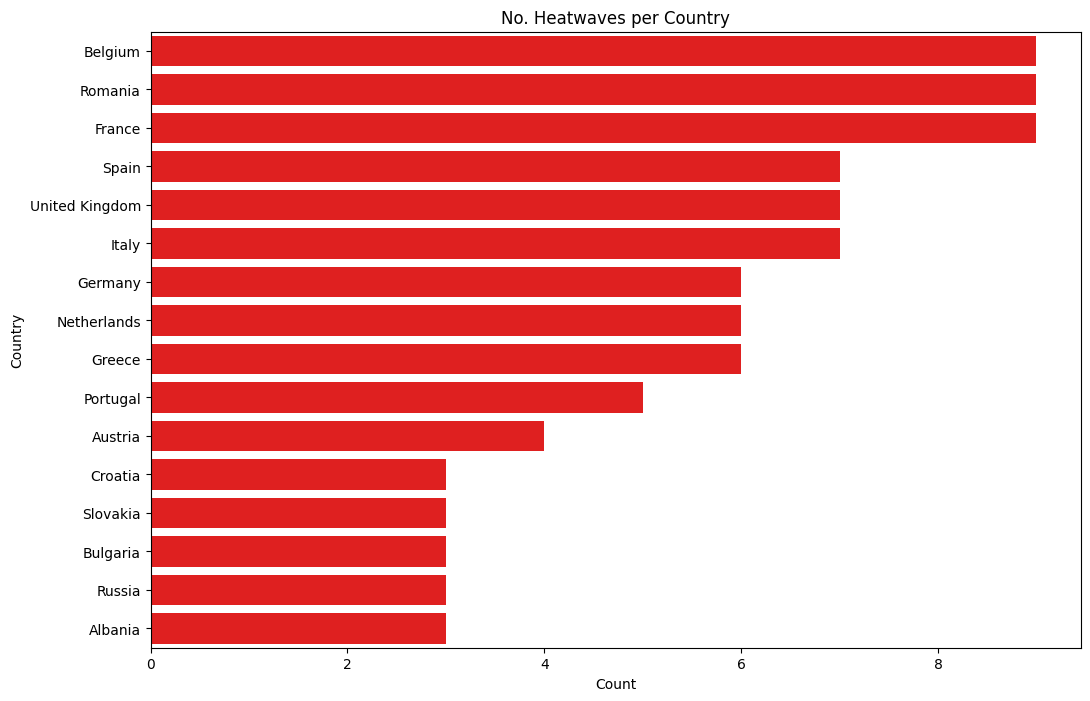

In [11]:
top_countries = heatwave_top_countries(df_heat, top, figsize=(12, 8))

In [12]:
def plot_deaths_overtime(df, name = 'death_over_years'):
    '''
    Missing data are now considered and plotted as grey dots
    '''
    data = df.groupby('Year')["Total Deaths"].sum().reset_index()

    plt.figure(figsize=(10, 6))

    plt.plot(data['Year'], data['Total Deaths'], marker='o', linestyle='-', color='blue', label='Total Deaths')
    
    all_years = np.arange(data['Year'].min(), data['Year'].max() + 1)
    missing_years = np.setdiff1d(all_years, data['Year'])
    if len(missing_years) > 0:
        missing_data = np.zeros(len(missing_years))
        plt.scatter(missing_years, missing_data, color='grey', marker='o', label='Missing Years')

    plt.xlabel('Year')
    plt.ylabel('Total Deaths')
    plt.title('Line Chart with Deaths')
    
    # Set x-axis ticks to include all years
    plt.xticks(all_years)
    plt.xticks(rotation=90)

    plt.legend()
    dir = '../images/'
    plt.savefig(dir + name + '.png')
    plt.show()

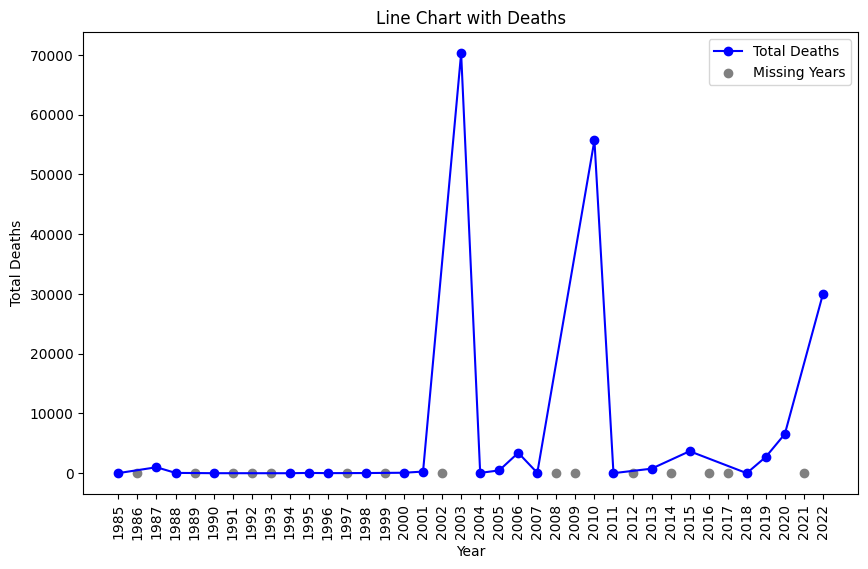

In [13]:
plot_deaths_overtime(top_countries)

Since we will later use number of deaths as the target variable, we have to exclude rows where this value is not present.

In [14]:
top_countries.shape

(90, 50)

In [23]:
top_countries_valid_death = top_countries[~top_countries['Total Deaths'].isna()]#.shape

In [16]:
top_countries_valid_death.shape

(69, 50)

After filtering out these rows, we save the dataframe as intermediate file 'country_focus', which will be processed by a separate notebook.

In [17]:
dfs = top_countries_valid_death.copy()
#dfs.to_csv('../data/processed/country_focus.csv')

In [18]:
def plot_country_year_mortality_heatmap(dfs, name = 'country_year_mortality_heatmap'):
    heatmap_data = dfs.pivot_table(index='Country', columns='Year', values='Total Deaths', aggfunc='sum')

    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False)
    plt.title('Number of Deaths by Country and Year')
    plt.xlabel('Year')
    plt.ylabel('Country')

    dir = '../images/'
    plt.savefig(dir + name + '.png', bbox_inches='tight')
    
    plt.show()

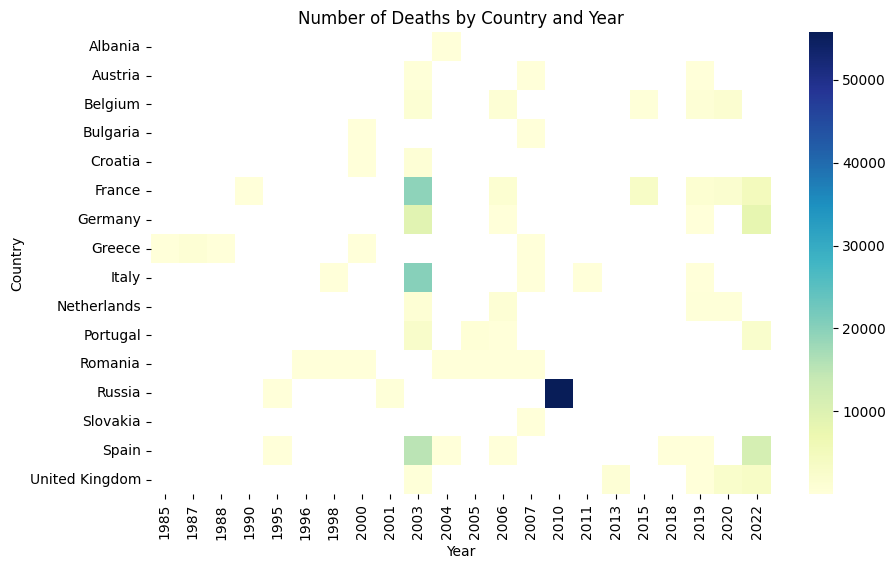

In [19]:
plot_country_year_mortality_heatmap(dfs)

In [37]:
def world_map(df, year):

    df = df[df['Year']==year]
    print(df.shape)
    
    fig = px.choropleth(df, locations='ISO', color='Total Deaths',
                        color_continuous_scale='RdYlGn_r', template="plotly_dark",
                        title="Worldwide Death Counts in " + str(year))
    
    fig.update_layout(mapbox_style="carto-positron",
                      mapbox_zoom=10)
    fig.update_layout(title_x=0.5, margin={"r":0, "t":30,"l":0,"b":0})
    
    fig.show()

world_map(dfs, 2003)

(10, 50)


In [39]:
def world_map(df, year):
    df = df[df['Year'] == year]
    print(df.shape)

    fig = px.choropleth(
        df,
        locations='ISO',
        color='Total Deaths',
        color_continuous_scale='RdYlGn_r',
        title="Worldwide Death Counts in " + str(year),
        template="plotly_dark"
    )

   # fig.update_geos(visible=False, lonaxisbordercolor='blue', lataxisbordercolor='blue')  # Remove boundary box

    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_zoom=10,
        title_x=0.5,
        margin={"r": 0, "t": 80, "l": 0, "b": 0},  # Adjust title position
        paper_bgcolor='lightblue'  # Set the background color to blue
    )

    fig.show()

world_map(dfs, 2003)

(10, 50)


In [41]:
import plotly.express as px

def world_map(df, year):
    df = df[df['Year'] == year]
    
    fig = px.choropleth(
        df,
        locations='ISO',
        color='Total Deaths',
        color_continuous_scale='RdYlGn_r',
        title="Worldwide Death Counts in " + str(year),
        template="plotly_dark"  # Set the dark template for the plot
    )

    fig.update_geos(visible=False, coastlinecolor='blue')  # Remove boundary box

    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_zoom=10,
        title_x=0.5,
        margin={"r": 0, "t": 80, "l": 0, "b": 0},  # Adjust title position
        paper_bgcolor='lightblue',  # Set the background color to blue
        font_color='darkblue'  # Set title and text color to dark blue
    )

    fig.show()

world_map(dfs, 2003)


In [43]:
import plotly.express as px

def world_map(df, year):
    df = df[df['Year'] == year]
    
    fig = px.choropleth(
        df,
        locations='ISO',
        color='Total Deaths',
        color_continuous_scale='RdYlGn_r',
        title="Worldwide Death Counts in " + str(year),
        template="plotly_dark"  # Set the dark template for the plot
    )

    fig.update_geos(visible=False, coastlinecolor='blue')  # Remove boundary box

    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_zoom=10,
        title_x=0.5,
        margin={"r": 0, "t": 80, "l": 0, "b": 0},  # Adjust title position
        paper_bgcolor='lightblue',  # Set the background color to blue
        font_color='darkblue',  # Set title and text color to dark blue
    )

    # Set the color of unselected countries to white
    fig.update_geos(
        projection_type='mercator',
        showland=True,
        landcolor='white',
    )

    fig.show()

world_map(dfs, 2003)


In [48]:
import plotly.express as px

def world_map(df, year):
    df = df[df['Year'] == year]
    
    fig = px.choropleth(
        df,
        locations='ISO',
        color='Total Deaths',
        color_continuous_scale='RdYlGn_r',
        title="Worldwide Death Counts in " + str(year),
        template="plotly_dark"  # Set the dark template for the plot
    )

    fig.update_geos(visible=False, coastlinecolor='blue')  # Remove boundary box

    fig.update_layout(
        mapbox_style="carto-positron",
        mapbox_zoom=10,
        title_x=0.5,
        margin={"r": 0, "t": 80, "l": 0, "b": 0},  # Adjust title position
        paper_bgcolor='lightblue',  # Set the background color to blue
        font_color='darkblue',  # Set title and text color to dark blue
    )

    # Set the color of unselected countries to white
    fig.update_geos(
        projection_type='mercator',
        showland=True,
        landcolor='white',
        oceancolor='darkblue'  # Set the ocean color to dark blue
    )

    fig.show()

world_map(dfs, 2003)
